# Call an Azure Function from Azure SQL DB

Make sure to have an Azure Function deployed in Azure to run the following samples. If you need help in creating your first Azure Function, please take a look here: [Getting started with Azure Functions](https://learn.microsoft.com/azure/azure-functions/functions-get-started). 

**Please note** that the Azure Function must have an [HTTP Trigger](https://learn.microsoft.com/azure/azure-functions/functions-bindings-http-webhook) to be able to be called by Azure SQL DB: [Azure Functions HTTP trigger](https://learn.microsoft.com/azure/azure-functions/functions-bindings-http-webhook-trigger)

In the next samples is assumed that there is an Azure Function with HTTP Trigger support deployed at `https://azure-sql-function.azurewebsites.net/api/sample-function`. To have the samples working in your environment make sure to use the URL of your Azure Function. 

## Call a public (or anonymous) Azure Function

If the function doesn't require any authentication, it can be called without any additional requirement

In [ ]:
declare @url nvarchar(4000) = N'https://azure-sql-function.azurewebsites.net/api/sample-function';
declare @headers nvarchar(4000) = N'{"header1":"value_a", "header2":"value2", "header1":"value_b"}'
declare @payload nvarchar(max) = N'{"some":{"data":"here"}}'
declare @ret int, @response nvarchar(max);

exec @ret = sp_invoke_external_rest_endpoint 
	@url = @url,
	@method = 'GET',
	@headers = @headers,
	@payload = @payload,
	@response = @response output;
	
select @ret as ReturnCode, @response as Response;

## Call an Azure Function protected by a secret key

Azure Funtions can be protected via the usage of a "authorization key" that must be passed to the function in order to execution to happen: [Authorization level](https://learn.microsoft.com/azure/azure-functions/functions-bindings-http-webhook-trigger?tabs=in-process%2Cfunctionsv2&pivots=programming-language-csharp#http-auth)

Since the authorization key is a sensitive value, it is recommended to store its value in a `DATABASE SCOPED CREDENTIAL` (more info here: [Credentials (Database Engine)](https://learn.microsoft.com/sql/relational-databases/security/authentication-access/credentials-database-engine))

In [ ]:
-- make sure a database master key exists
if not exists(select * from sys.symmetric_keys where [name] = '##MS_DatabaseMasterKey##') begin
    create master key encryption by password = 'LONg_Pa$$_w0rd!'
end

-- create database scoped credential
create database scoped credential [https://azure-sql-function.azurewebsites.net/api/sample-function]
with identity = 'HTTPEndpointHeaders', secret = '{"x-functions-key":"<your-function-key-here>"}';
go

Once the `DATABASE SCOPED CREDENTIAL` has been defined, it can be used by anyone who has been granted the `REFERENCE` permissions on it (see: [Grant permissions to use credential](https://learn.microsoft.com/sql/relational-databases/system-stored-procedures/sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current&tabs=request-headers#grant-permissions-to-use-credential)):

In [ ]:
declare @url nvarchar(4000) = N'https://azure-sql-function.azurewebsites.net/api/sample-function';
declare @headers nvarchar(4000) = N'{"header1":"value_a", "header2":"value2", "header1":"value_b"}'
declare @payload nvarchar(max) = N'{"some":{"data":"here"}}'
declare @ret int, @response nvarchar(max);

exec @ret = sp_invoke_external_rest_endpoint 
	@url = @url,
	@method = 'GET',
	@headers = @headers,
	@payload = @payload,
    @credential = [https://azure-sql-function.azurewebsites.net/api/sample-function],
	@response = @response output;
	
select @ret as ReturnCode, @response as Response;

## Call an Azure Function protected by Azure AD

Make sure you have enabled the Managed Identity support for the Azure SQL Server related to the database you are using to call the Azure Function, or via AZ CLI:

```
az sql server update -g <resource-group> -n <azure-sql-server> --identity-type SystemAssigned

```

or via the the Azure Portal

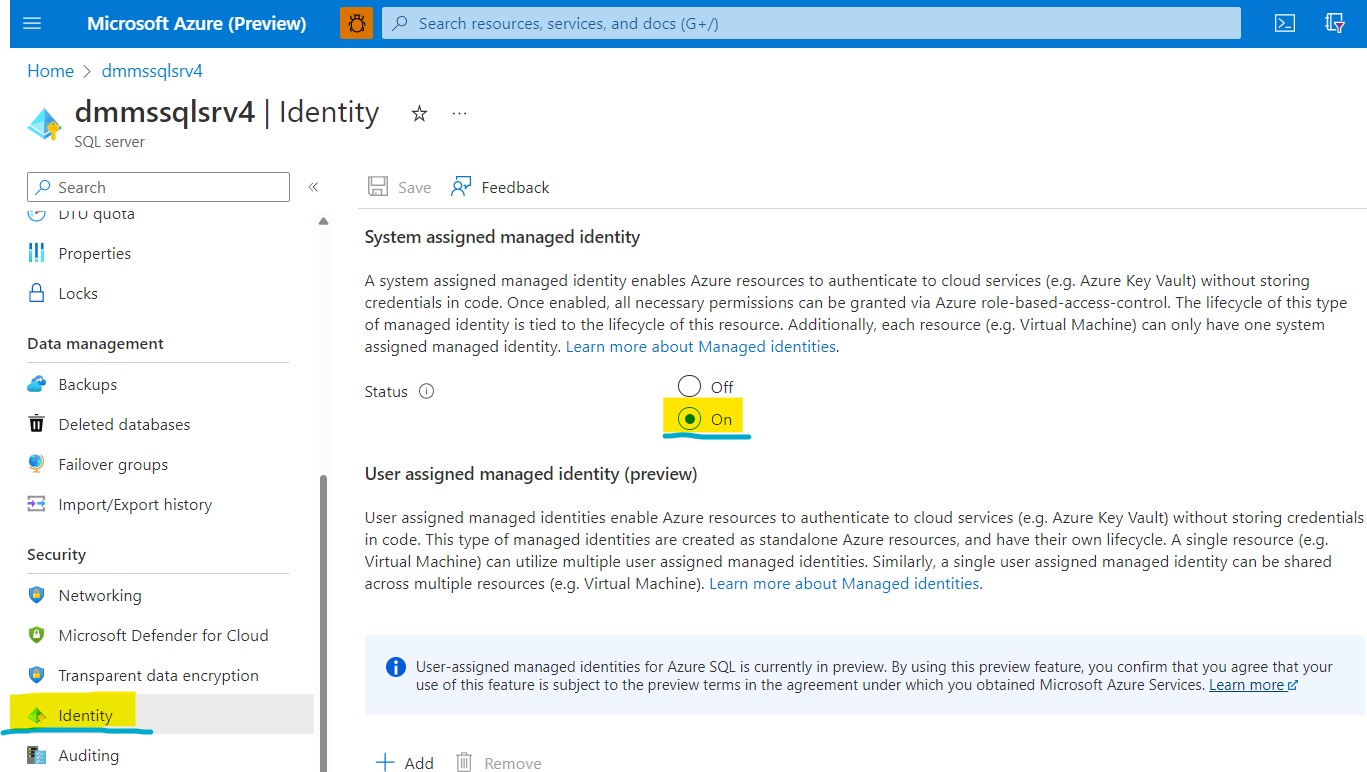

and then enable Azure AD authentication in your Azure Function as explained here: [Tutorial: Add app authentication to your web app running on Azure App Service](https://learn.microsoft.com/azure/app-service/scenario-secure-app-authentication-app-service).

After the Azure AD principal has been enabled on Azure Function, you'll see that there is a App (client) ID available (for example: `02f5c654-0d70-4074-a82f-40d6a0dce8ff`). The provided App ID must be used to allow Azure SQL Database to correctly make the authenticated call to the Azure Function. Create a `DATABASE SCOPED CREDENTIAL` and specify `Managed Identity` as the `identity` value. The `secrect` value must be a flat JSON that contains the APP ID value in the `resourceid` property:

In [ ]:
-- make sure a database master key exists
if not exists(select * from sys.symmetric_keys where [name] = '##MS_DatabaseMasterKey##') begin
    create master key encryption by password = 'LONg_Pa$$_w0rd!'
end

-- create database scoped credential
create database scoped credential [https://azure-sql-function.azurewebsites.net/api/sample-function]
with identity = 'Managed Identity', secret = '{"resourceid":"02f5c654-0d70-4074-a82f-40d6a0dce8ff"}';
go

Once the `DATABASE SCOPED CREDENTIAL` has been defined, it can be used by anyone who has been granted the `REFERENCE` permissions on it (see: [Grant permissions to use credential](https://learn.microsoft.com/sql/relational-databases/system-stored-procedures/sp-invoke-external-rest-endpoint-transact-sql?view=azuresqldb-current&tabs=request-headers#grant-permissions-to-use-credential)):

In [ ]:
declare @url nvarchar(4000) = N'https://azure-sql-function.azurewebsites.net/api/sample-function';
declare @headers nvarchar(4000) = N'{"header1":"value_a", "header2":"value2", "header1":"value_b"}'
declare @payload nvarchar(max) = N'{"some":{"data":"here"}}'
declare @ret int, @response nvarchar(max);

exec @ret = sp_invoke_external_rest_endpoint 
	@url = @url,
	@method = 'GET',
	@headers = @headers,
	@payload = @payload,
    @credential = [https://azure-sql-function.azurewebsites.net/api/sample-function],
	@response = @response output;
	
select @ret as ReturnCode, @response as Response;